In [319]:
import numpy as np
import re
import nltk
from matplotlib import pyplot as plt
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)



#############################################################################

X_train= np.array(X_train).reshape((1401,1500)) 
y_train= np.array(y_train).reshape((1401,1))
X_test = np.array(X_test).reshape((601,1500))
y_test = np.array(y_test).reshape((601,1))

#############################################################################
def layer_structure(x, y, hidden_size):
    """
    Input:
        x: predictors
        y: response variable
        hidden_size: number of neurons in the hidden layer
        
    Output:
        input_size: number of predictors in input dataset
        hidden_size: number of neurosn in hidden layer
        output_size: number of possible prediction outputs  
    """
    input_size = x.shape[0]
    hidden_size = hidden_size
    output_size = y.shape[0]
    
    return (input_size, hidden_size, output_size)
############################################################################
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Input:
        Sizes of input, hidden, and output layer
    Output:
        
    """
    W_1 = np.random.randn(hidden_size, input_size) * 0.001
    b_1 = np.zeros((hidden_size, 1))
    W_2 = np.random.randn(output_size, hidden_size) * 0.001
    b_2 = np.zeros((output_size, 1))
    
    parameters = {'W1':W_1,
                  'b1':b_1,
                  'W2':W_2,
                  'b2':b_2}
    
    return parameters
#################################################################
def tanh(z):
    """
    Inputs z and outputs the tanh of z
    """
    
    t = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    
    return t


def sigmoid(z):
    """
    Inputs z and outputs the sigmoid of z
    """
    
    s = 1/(1+np.exp(-z))
    
    return s
##############################################
def forward_propagation(x, parameters):
    """
     Taking the input X along with the parameters and computing the output                                             
    """
    
    #retrieving the initialized parameters from the 'parameters' dictionary
    W_1, b_1, W_2, b_2 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2']
    
    #computing the linear and activation part of both the hidden and the output layer
    Z_1 = np.dot(W_1, x) + b_1
    A_1 = sigmoid(Z_1)
    Z_2 = np.dot(W_2, A_1) + b_2
    A_2 = sigmoid(Z_2)
    
    #storing results in new dictionary called 'cache'
    cache = {'Z1': Z_1,
             'A1': A_1,
             'Z2': Z_2,
             'A2': A_2}
    
    return cache
##################################################
def compute_loss(A2, y, parameters):
    """
    Computing the cross-entropy loss
    """
    
    n_observations = y.shape[1]
    
    loss = 1/n_observations * np.sum(y*np.log(A2) + (1-y)*np.log(1-A2))
    
    loss = np.squeeze(loss)
    
    return loss



def backpropagation(parameters, cache, x, y):
    """
    Taking the derivatives in backprop
    """
    
    m = x.shape[1] #number of observations
    
    #retrieving parameters as well as calculated output from forward propagation
    W1 = parameters['W1']
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    #calculating the derivatives
    dZ2 = A2 - y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, x.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads


def update_parameters(parameters, grads, learning_rate = 1):
    """
    Updating the parameters after backprop
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#############################################

def neural_net(x, y, hidden_size, iterations = 1000):
    """
    Putting all functions together to form a neural network
    """
    input_size = len(x)
    print(input_size)
    output_size = len(y)
    print(output_size)
    
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    costs=[]
    
    for i in range(0, iterations): #gradient descent
         
        cache = forward_propagation(x, parameters) #forward prop
        A2 = cache['A2']
        
        cost = compute_loss(A2, y, parameters) #computing the cost of our output
        costs.append(cost)
 
        grads = backpropagation(parameters, cache, x, y) #taking the derivatives
 
        parameters = update_parameters(parameters, grads) #updating our parameters
    return costs,parameters
######################################
costs,parameters = neural_net(X_train,y_train,100,1000)
costs_t,parameters_t = neural_net(X_test,y_test,100,1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ihbor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ihbor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


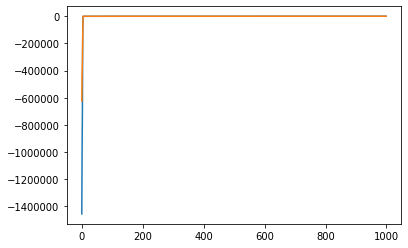

In [311]:
plt.plot(costs)
plt.plot(costs_t)

In [318]:




cache=forward_propagation(X_train, parameters)
cache_t=forward_propagation(X_test, parameters_t)
A2 = cache['A2']
A2_t = cache_t['A2']
y_pred_test = A2_t
y_pred_train = A2


print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train))

print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets